<a href="https://colab.research.google.com/github/heyaozh/RL_Trading/blob/main/QuantTrading_RL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our Task

1. You are given 50 stocks from the S&P500 universe. Use a value-weighted (market-cap-weighted) portfolio of these stocks from 01/2000 until 12/2019 as your starting point, that is, as your benchmark portfolio [BNCH]. 
2. Using the in-sample period from 01/2000 until 12/2012, create a quant strategy [QS] that improves upon the BNCH in terms of performance under specific constraints. 
3. Using the model that you selected in the in-sample period (e.g., LASSO, or RIDGE, etc), create your QS, analyze and report performance for the out-of-sample period from 1/2013 until 12/2019; you still can use a rolling window approach, re-estimate model parameters, but you do not change your model in this period. 
4. Performance metrics and constraints: 
    * Performance can be measured in terms of Sharpe Ration, Variance, Excess Return w.r.t. BNCH. For example, you achieve positive and statistically significant excess return given the same or lower variance, or lower variance conditional on the same or higher excess return.
    * Constraints imposed:
        * Factor exposure deviation from BNCH max 0.05 [for each considered factor]. For example, if the benchmark has 20% Value Factor exposure (beta), let the target portfolio deviate at most 5% with respect to the 20% exposure (i.e., to be between 15% and 25%).
        * Weight deviation for each asset max 10% of the BNCH weight, i.e., if the weight of an asset is 1%, the weight of that asset in your portfolio can be between 0.9% and 1.1%. 
        * Drawdown relative to BNCH max 1% per month [that is, QS shall not lose more than 1% of its value per month compared to the BNCH].

# What can you find in this notebook?

In this document, we show **how Reinforcement Learning (RL) can be used for stock trading.** In short, RL is a model free method to get a task done in certain environment. Recently, we have famous RL-based AlphaGo that can defeat human professionals.

RL requires a pre-defined environment, action spaces and reward function where data will be fed into it and feedback will be given. Then an agent will observe the current state in the **environment** and try out different **actions** it allows to take under the situation. The environment will give it a feedback, or so called **reward**. The agent will remember the situation, its action and the reward.

In the training window, the agent will try again and again and collect the failed and successful experience. Then it will use a neural network to connect those observations, actions and rewards. Thus it will learn from the trials how it should act in certain condition.

After some time of training, it will less and less take random action but rather pick the action that can maximize its expected reward suggested from the neural network based on its past experience.

As you can see, this is pretty much like human's learning procedure, but the agent is absolute rational and will always remember the past things. In this way, even the environment changes, or to say, the underlying joint probability distribution of variables changes (schema shift), it can still take some time to learn the new environment. This is the superior advantage over other statistical or machine learning models. However, the most challenge thing here is to define the environment, possible actions and reward function. If one is not well defined, the agent may never learn things or will learn very slow.

Due to time limit of this project, we cannot try many models since training a kid from zero is not a easy task. This notebook is more like illustration purpose to show how we can tackle the trading problem with given constraints by using RL. Again, **due to the time limit, our target here is to defeat the benchmark (slightly) considering the constraints rather than optimizing.**

As far as we heard (not sure), there are already successful RL algorithms deployed in high-frequency market making that can provide liquidity, gain profits and keep inventory at a low level. Since training a RL requires a lot of data, there are also recent development using Generative Adversarial Network (GAN) to generate realistic data to train RL agents (or for other backtesting purpose).

We use this notebook solely for our RL model because it requires GPU and TensorFlow 1.x to run, which are free and easy to set up in Google Colab but will be very expensive on other server or trouble some at local. 

**Note**: This model is very time consuming and has relatively high randomness compared to machine learning models, so the reproduction results will be slightly different than the results shown in this notebook. Please make a copy and refer to other *Note* in markdown cells if you would like to rerun everything.

In [ ]:
# !pip install wrds
# !pip install statsmodels==0.12.2
!pip install stable_baselines
!pip install quantstats

     |████████████████████████████████| 245kB 8.1MB/s 
     |████████████████████████████████| 5.5MB 14.5MB/s 
  Created wheel for quantstats: filename=QuantStats-0.0.30-py2.py3-none-any.whl size=37558 sha256=5a3f3cb34f34dbac363325898b2c3617f79c4b41c53d7d774d5f3c0ac6ce5a12
  Stored in directory: /root/.cache/pip/wheels/31/db/34/54c708002e3485dc8a4556589510f84e2d75ba1d3c7ee5d5a1
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=407a91e16e74fa7908d6b5c97628e3775f9e78ac42db1c00b8af5251daeb5645
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built quantstats yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import datetime
import time
# import wrds
import gym
import matplotlib.pyplot as plt
import pandas_datareader as web
import quantstats as qs
# from statsmodels.regression.rolling import RollingOLS

TensorFlow 1.x selected.


In [ ]:
pd.set_option('display.max_columns', 50)
start_date = '2000-01-01'
end_date = '2019-12-31'
cut_date = '2012-12-31'
# permnos = pd.read_csv('permno_selection.csv').permno.astype(int).to_list()

**NOTE:** The data pipeline can be found in attachment.

We use daily data in this RL model because RL requires large amount of data. Monthly and weekly data may not perform well according to our trials.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Quant/panel.csv')

In [ ]:
df['date'] = pd.to_datetime(df.date)
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251550 entries, 0 to 251549
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          251550 non-null  datetime64[ns]
 1   permno        251550 non-null  int64         
 2   cusip         251550 non-null  object        
 3   ret           251550 non-null  float64       
 4   prc           251550 non-null  float64       
 5   shrout        251550 non-null  float64       
 6   askhi         251550 non-null  float64       
 7   bidlo         251550 non-null  float64       
 8   openprc       251550 non-null  float64       
 9   vol           251550 non-null  float64       
 10  mkt_cap       251550 non-null  float64       
 11  mkt_capL      251500 non-null  float64       
 12  sum_mkt_capL  251550 non-null  float64       
 13  BNCH_weight   251500 non-null  float64       
 14  BNCH_ret      251500 non-null  float64       
 15  BNCH_ret_fw   251

,date,permno,cusip,ret,prc,shrout,askhi,bidlo,openprc,vol,mkt_cap,mkt_capL,sum_mkt_capL,BNCH_weight,BNCH_ret,BNCH_ret_fw,mktrf,smb,hml,rf,mom,ex_ret,constant,secid,skew,iv,mfis30,glb3_D30,real_vol,ret1w,cvar,vrp,volume_cap
251545,2019-12-31,83601,98181110,-0.005658,42.180000,55094.0,42.900002,42.169998,42.369999,217647.0,2.323865e+06,2.372296e+06,2.844658e+09,0.000834,-0.000005,0.000003,1.470382,1.154803,0.631754,0.00007,-0.097047,-0.005728,-0.000090,112136.0,-0.482286,0.365589,-1.742145,0.115309,0.108104,-0.013564,-0.042242,0.257485,0.093657
251546,2019-12-31,84519,17177930,0.001173,42.689999,154054.0,42.869999,42.320000,42.430000,1627046.0,6.576565e+06,6.596237e+06,2.844658e+09,0.002319,0.000003,-0.000042,1.507038,-0.156548,0.605991,0.00007,0.321576,0.001103,-0.000146,103022.0,-0.059538,0.268244,-0.384521,0.018802,0.404370,0.007790,-0.042841,-0.136126,0.247401
251547,2019-12-31,85663,91136310,-0.009444,166.770004,75156.0,169.369995,166.360001,167.699997,617502.0,1.253377e+07,1.265326e+07,2.844658e+09,0.004448,-0.000042,-0.000009,1.831732,0.443500,0.513004,0.00007,-0.644769,-0.009514,0.000514,111436.0,-0.066739,0.343555,-0.514702,0.061226,0.057497,-0.012728,-0.050205,0.286059,0.049267
251548,2019-12-31,86102,31421110,-0.007613,32.590000,101130.0,32.939999,32.520000,32.779999,330055.0,3.295827e+06,3.321109e+06,2.844658e+09,0.001167,-0.000009,0.000008,0.856432,0.402458,0.984430,0.00007,0.426579,-0.007683,0.000529,104634.0,-0.286031,0.333702,-1.679461,0.077167,0.028463,-0.007008,-0.032205,0.305239,0.100143
251549,2019-12-31,88664,42628110,0.001926,145.669998,76714.0,145.794998,144.899994,145.160004,273862.0,1.117493e+07,1.118587e+07,2.844658e+09,0.003932,0.000008,NaN,0.935995,-0.152087,0.054002,0.00007,0.349998,0.001856,-0.000360,105683.0,-0.067007,0.183090,-0.002984,0.036485,0.012226,-0.004442,-0.026809,0.170864,0.024507


In our panel data, we will only need the following columns. Actually, after several trials, we will further shrink the feature space to reduce the computational power required while still keep relatively good performance.


In [ ]:
df = df.loc[:, ['date', 'permno', 'ret', 'ret1w', 'BNCH_weight', 
                'mktrf', 'smb', 'hml', 'mom', 'skew', 'iv',
                'mfis30', 'glb3_D30', 'cvar', 'vrp', 'volume_cap']]
df.head()

,date,permno,ret,ret1w,BNCH_weight,mktrf,smb,hml,mom,skew,iv,mfis30,glb3_D30,cvar,vrp,volume_cap
0,2000-01-03,10874,-0.014045,NaN,NaN,NaN,NaN,NaN,NaN,-0.006316,0.380492,0.090101,0.019978,NaN,NaN,0.142321
1,2000-01-03,11308,-0.032189,NaN,NaN,NaN,NaN,NaN,NaN,-0.070132,0.365575,-0.389598,0.045722,NaN,NaN,0.039484
2,2000-01-03,11404,-0.021739,NaN,NaN,NaN,NaN,NaN,NaN,-0.069636,0.274926,0.840749,0.042202,NaN,NaN,0.079365
3,2000-01-03,11786,0.070707,NaN,NaN,NaN,NaN,NaN,NaN,-0.305234,0.592066,-1.050437,0.025213,NaN,NaN,0.179262
4,2000-01-03,13856,0.046099,NaN,NaN,NaN,NaN,NaN,NaN,-0.072041,0.339448,-0.386412,0.042048,NaN,NaN,0.098692


Here we reset the start date to be the first date contains all data for training purpose.

In [ ]:
start_date = df.dropna().iloc[0,0]
start_date

Timestamp('2000-12-29 00:00:00')

In [ ]:
df.describe()

,permno,ret,ret1w,BNCH_weight,mktrf,smb,hml,mom,skew,iv,mfis30,glb3_D30,cvar,vrp,volume_cap
count,251550.000000,251550.000000,251350.000000,251500.000000,239000.000000,239000.000000,239000.000000,239000.000000,251521.000000,251521.000000,251521.000000,251521.000000,239000.000000,250071.000000,251550.000000
mean,43894.560000,0.000549,0.002710,0.020000,0.935672,0.108362,0.029073,-0.071600,-0.108975,0.349831,-0.526951,0.084844,-0.042930,0.200547,0.591409
std,25671.049577,0.024252,0.053059,0.031333,0.424307,0.557497,0.677814,0.529466,0.116878,0.204871,0.528816,0.116539,0.026893,0.225174,1.523356
min,10874.000000,-0.418152,-0.633889,0.000164,-0.752962,-2.741940,-5.012431,-4.080260,-2.309354,0.091655,-2.501104,-0.013655,-0.218693,-9.579899,0.000000
25%,20482.000000,-0.008616,-0.018537,0.002659,0.638633,-0.290641,-0.335350,-0.301506,-0.128011,0.198523,-0.794382,0.025492,-0.052961,0.150841,0.068833
50%,44680.000000,0.000417,0.002698,0.007430,0.873147,-0.045266,-0.015447,-0.011914,-0.077284,0.298992,-0.495922,0.050122,-0.035638,0.201533,0.145744
75%,69032.000000,0.009464,0.023271,0.019892,1.219039,0.417909,0.372755,0.209050,-0.050496,0.430971,-0.224797,0.098473,-0.023803,0.271148,0.436332
max,88664.000000,0.869835,1.017203,0.174370,3.534897,3.175678,4.974733,2.444305,1.316669,2.639363,1.397121,1.437665,-0.010107,1.882147,71.358862


Let's have a look of the correlation between features. Many features are correlated on a linear spaces, they are marked below with a threshold larger than $0.45$ (or smaller than $-0.45$).

In [ ]:
features = ['mktrf', 'smb', 'hml', 'mom', 'skew', 'iv', 'mfis30'    , 'glb3_D30', 'cvar', 'vrp', 'volume_cap']
df.loc[df.date <= pd.to_datetime(cut_date), features].corr()

# mktrf ~ smb
# mktrf ~ iv
# mktrf ~ cvar
# smb ~ iv
# smb ~ cvar
# skew ~ mfis30
# iv ~ glb3_D30
# iv ~ cvar
# iv ~ volume_cap
# glb3_D30 ~ cvar
# cvar ~ volume_cap

,mktrf,smb,hml,mom,skew,iv,mfis30,glb3_D30,cvar,vrp,volume_cap
mktrf,1.000000,0.514643,0.041305,-0.183887,-0.093926,0.486324,0.100223,0.298826,-0.519452,-0.033721,0.308881
smb,0.514643,1.000000,0.060641,-0.191556,-0.065780,0.473953,0.161506,0.237080,-0.443305,0.082689,0.319668
hml,0.041305,0.060641,1.000000,0.035426,-0.092921,-0.058104,-0.032470,-0.037478,0.060313,0.044118,-0.049754
mom,-0.183887,-0.191556,0.035426,1.000000,0.086316,-0.354480,-0.052952,-0.227358,0.379247,0.118704,-0.280493
skew,-0.093926,-0.065780,-0.092921,0.086316,1.000000,-0.214008,0.529368,-0.400980,0.112877,0.045304,0.041099
iv,0.486324,0.473953,-0.058104,-0.354480,-0.214008,1.000000,0.176444,0.735352,-0.848348,-0.216354,0.492789
mfis30,0.100223,0.161506,-0.032470,-0.052952,0.529368,0.176444,1.000000,-0.015132,-0.150422,0.023154,0.151153
glb3_D30,0.298826,0.237080,-0.037478,-0.227358,-0.400980,0.735352,-0.015132,1.000000,-0.553152,-0.215285,0.357744
cvar,-0.519452,-0.443305,0.060313,0.379247,0.112877,-0.848348,-0.150422,-0.553152,1.000000,0.219453,-0.493561
vrp,-0.033721,0.082689,0.044118,0.118704,0.045304,-0.216354,0.023154,-0.215285,0.219453,1.000000,-0.134047


Above correlation matrix only accounts for **linear** correlations, which may not be reliable. After several trials, and consider computational power and time limit, we select only 6 features for further modelling. They are `mktrf`, `smb`, `hml`, `mom`, `mfis30`, `glb3_D30`. 

I drop `skew` and `volume_cap` because `mfis30` indicates also the skewness and `volume_cap` accounts for technical analysis that may not be in our scope. Then we trim the rest variables to $-10$ to $10$, so that it agrees with the RL environment space below. However, effectively, no historical data falls beyond this range, so all past observations can be pretty good considered.

In our final selection, the first four variables are betas from Fama French model. As they are derived using rolling basis on past annual data, so we can assume that they carry the information from the past. The other option related features then imply the market consensus expectation of future. We believe our agent can learn to derive the currect expectation and act on it to defeat the benchmark.

In our data extraction and preprocessing, no information is transformed using future information (e.g. normalization of whole period) so there is **no leakage from future**. Every thing happens on rolling basis for past periods.

In [ ]:
features = ['mktrf', 'smb', 'hml', 'mom', 'iv', 'mfis30', 'glb3_D30', 'cvar', 'vrp']
for c in ['mktrf', 'smb', 'hml', 'mom', 'iv', 'mfis30', 'glb3_D30', 'cvar', 'vrp']:
    df.loc[df[c] >  10, c] =  10
    df.loc[df[c] < -10, c] = -10 

# Deep Reinforcement Learning Setup

We first create an environment for the agent to learn. In our environment, we take care also the constraints. We will first give an overview for some functions, and the detail will be explained in comments.

* The function `__init__()` will initiate the environment. It will take a `pd.DataFrame` as input and get the data on first day. Also the candidate actions and observations will be defined and the memory for the agent will be initialized.

* The function `reset()` will reset the environment, it will be called when the agent learns again from the environment (a new episode).

* The function `diverged()` will check whether the constraints are met or not.

* The function `adj_weights()` will shrink the weights closer to the benchmark weights if the constraints conditions are not met. After the iterative adjustment, the weights of portfolio will be closer and closer to benchmark weights until all constraints are satisfied.

* The function `step()` is the most important function here, it regulates how the agent will act. It will move to the next day, calculate the return and reward, which is the difference between return and benchmark return. The observation states will also be updated. If it reach until the last day, this episode will be terminated, sharpe ratio and other statistics will be saved.

Our strategy is reflected by the `step()` function as well. It can be summarized as followings:

1. Initially, the agent choose the same weights of stocks as the benchmark weights.

2. During training, it will randomly pick a move or pick the move that can maximize expected rewards according to its experience and based on current observations (exploration and exploitation). The probability that it pick a random move will decrease gradually so that it will learn from fail experience at the beginning and perform better and better. This is not reflected in the environment but is the basic idea of the model, which we will discuss after the environment setup.

3. The return with respect to the selected weights and the benchmark return will be calculated, the difference is the reward the agent will get. Thus it is motivated to defeat the benchmark because it wants positive rewards.

4. It will take action and choose new weights, **the weights will be adjusted to fulfill the constraints ruled by the function `adj_weights()`.** New weights and other stats such as betas will be updated to new observations.

5. Then it will come to the next day and repeat step 2 to step 4 again.

**Note** that the last constraints that the maximum drawdown is softly governed by the reward definition, which is the difference between the portfolio return and benchmark return. Thus the agent will avoid negative value of this difference on daily basis, so the maximum drawdown is highly unlikely to be 1% larger than that of benchmark.

We use the OpenAI API `gym` to define the environment.





In [ ]:
STOCK_DIM = 50       # number of stocks
# TRANS_FEE = 0.001  # assume no fee

In [ ]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, day=0, 
                 features=['mktrf', 'smb', 'hml', 'mom', 'mfis30', 'glb3_D30']):  
                 # iv, vrp as well? dimension will be to high! Compute slow!
        self.day = day            # the nth day
        self.df = df              # the panel data
        self.features = features  # features to be considered
        self.episode = 1          # for counting purpose
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(STOCK_DIM,))
        # The action space is following normal distribution, the value beyond
        # -1 and 1 will be clipped to -1 and 1. In later steps, this value will
        # be divided by 10 and multiplied by benchmark weights, so the single
        # stock weights will never exceed 10% of benchmark weights.
        
        self.observation_space = gym.spaces.Box(low=-10, high=10, 
                                                shape=(100+50*len(self.features),))  
        # We assume the variables cannot go beyond +/-10, which agrees with
        # out historical data. This will be the main part for the agent
        # to take actions.
        # The shape indicates: 
        # 50 [Last Return] +
        # 50 [Weights] +
        # 50 [Shares] * len(features)  
        # Here contains the information calculated from past and implied
        # from future. I tried using daily or weekly return, but daily
        # return performs better in our case.
        
        self.data = self.df.loc[self.day, :]   # The daily data
        self.terminal = False                  # a flag whether terminated
        self.bnch_weight = self.benchmark_weight(self.day)  # get BNCH weights
        self.weight = self.bnch_weight         # Originally weight same as BNCH.

        # Initialize observation states:
        feature_state = []
        for f in self.features:
            feature_state += self.data[f].values.tolist()
        self.state = self.data.ret.values.tolist() + self.weight + feature_state
        # The dimension of state and observation_space is the same.
        
        # Initialize memory buffer:
        self.asset_memory = [0]                # memory of absolute return  
        self.bnch_asset_memory = [0]           # memory of BNCH return
        # memory of weights:
        self.weight_memory = pd.DataFrame(columns=self.data.permno.unique())
        self.bnch_weight_memory = pd.DataFrame(columns=self.data.permno.unique())
        # memory of rewards (alpha) and sharpe ratio:
        self.rewards_memory = []
        self.sharpe_memory = []

        # self.trades = 0  # this can be activated when transaction fee is introduced.
        self.reward = 0    # initial reward
        self._seed()       # set random seed

    def benchmark_weight(self, day):
        # get benchmark weights of that day.
        return self.df.loc[day, 'BNCH_weight'].values.tolist()

    def _seed(self, seed=None):
        # random seed.
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
    def render(self, mode='human'):
        # give human-readable state.
        return self.state
    
    def reset(self):
        # This function is similar to the initialization.
        # One more episode:
        self.day = 0
        # self.episode += 1         # moved to termination step
        self.data = self.df.loc[self.day, :]
        self.terminal = False 
        self.bnch_weight = self.benchmark_weight(self.day)
        self.weight = self.bnch_weight

        # Initialize:
        feature_state = []
        for f in self.features:
            feature_state += self.data[f].values.tolist()
        self.state = self.data.ret.values.tolist() + self.weight + feature_state

        self.asset_memory = [0]
        self.bnch_asset_memory = [0]
        self.weight_memory = pd.DataFrame(columns=self.data.permno.unique())
        self.bnch_weight_memory = pd.DataFrame(columns=self.data.permno.unique())
        self.rewards_memory = []
        # self.trades = 0
        self.reward = 0
        return self.state

    def step(self, actions):
        # The agent acts based on this function:
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        
        if self.terminal == False:
            # If not the last day:

            # Next day and next daily data:
            self.day += 1
            self.data = self.df.loc[self.day, :]   # to yesterday's factor

            # Update total asset, memory and reward:
            return_ = sum(self.data.ret * self.weight)
            self.asset_memory.append(return_)
            bnch_return_ = sum(self.data.ret * self.bnch_weight)
            self.bnch_asset_memory.append(bnch_return_)
            # reward will be scaled to be easier to differentiate:
            self.reward = (return_ - bnch_return_) * 100  
            self.rewards_memory.append(self.reward)

            # Take action to get weights:
            self.bnch_weight = self.benchmark_weight(self.day)
            # Here, we tried not rebalance daily, but rather weekly or monthly,
            # or dynamically when there is a divergence from benchmark more than
            # constraints, but the performance is worse than daily rebalancing.
            # This could happen because we do not introduce transaction fee,
            # so the agent is not punished by frequent trading.
            # An example condition that rebalancing happens when there is 
            # divergence or every five days:
            # if self.diverged() or self.day % 5 == 0:

            # Weights between +/-10% corridor of BNCH:
            self.weight = (np.array(actions)/10 + 1) * np.array(self.bnch_weight)
            self.weight = self.weight / sum(self.weight)  # normalize to 1 sum
            self.weight = self.adj_weights()   # shrink when exceed BNCH factors
            self.weight = self.weight.tolist() # keep it in list
            
            # Update weights memory:
            self.weight_memory.loc[len(self.weight_memory)] = self.weight
            self.bnch_weight_memory.loc[len(self.weight_memory)] = self.bnch_weight

            # Update next state:
            feature_state = []
            for f in self.features:
                feature_state += self.data[f].values.tolist()
            self.state = self.data.ret.values.tolist() + self.weight + feature_state

            
        else:  # if terminal
            # Save asset development (returns)
            df_total_value = pd.DataFrame(self.asset_memory)
            df_bnch_value = pd.DataFrame(self.bnch_asset_memory)
            df_total_value.columns = ['daily_return']
            df_bnch_value.columns = ['bnch_daily_return']
            df_total_value = pd.concat([df_total_value, self.weight_memory], axis=1)
            df_bnch_value = pd.concat([df_bnch_value, self.bnch_weight_memory], axis=1)

            # Calculate and save Sharpe ratios
            sharpe = (252**0.5) * df_total_value['daily_return'].mean() / df_total_value['daily_return'].std()
            bnch_sharpe = (252**0.5) * df_bnch_value['bnch_daily_return'].mean() / df_bnch_value['bnch_daily_return'].std()
            print(f"Episode {self.episode}: Sharpe ratio = {round(sharpe,4)}; BNCH Sharpe ratio = {round(bnch_sharpe,4)}")
            df_total_value.to_csv(f'/content/drive/My Drive/Quant/20210327/ptf_return_train_{self.episode}_sp{round(sharpe,4)}.csv')
            df_bnch_value.to_csv(f'/content/drive/My Drive/Quant/20210327/bnch_return_train_{self.episode}_sp{round(sharpe,4)}.csv')
            with open(f'/content/drive/My Drive/Quant/20210327/sharpe_train.txt', 'a+') as f:
                f.write(f'{sharpe}, {bnch_sharpe}')
                f.write('\n')
            
            # Plot and save
            plt.plot(np.array(self.asset_memory).cumsum(), 'r')
            plt.plot(np.array(self.bnch_asset_memory).cumsum(), 'b')
            plt.savefig(f'/content/drive/My Drive/Quant/20210327/return_train_{self.episode}_sp{round(sharpe,4)}.png')
            plt.close()
            
            # one more episode
            self.episode += 1

            # NOTE here the files being saved will be huge!!! 
            # Be cautious and disable the function if necessary.

        return self.state, self.reward, self.terminal, {}    
    

    def adj_weights(self):
        # Weights will be diverged from BNCH for max 10% as defined 
        # in the action space, now we need to adjust the weights so
        # that the factor exposure does not exceed 5% of that of BNCH.

        # The matrix of betas: 50 * 4
        betas = self.data.loc[:,['mktrf', 'smb', 'hml', 'mom']].to_numpy()
        w = np.array(self.weight)
        b = np.array(self.bnch_weight)
        # The portfolio exposure to betas: 1*50 @ 50*4 = 1*4
        w_expo = np.expand_dims(w, axis=0) @ betas
        b_expo = np.expand_dims(b, axis=0) @ betas
        # Divergence:
        diff = w_expo / b_expo - 1
        # Schrink weights to be closer to BNCH to reduce the exposure:
        j = 0  # control for max iteration (never reached...)
        while (abs(diff) >= 0.05).sum() > 0 and j <= 1000:
            # while there is a divergence.
            w[w > b] *= 0.99  # larger-than-BNCH-weights schrinks.
            w[w < b] *= 1.01  # lower-than-BNCH-weights increases.
            # So that all weights move closer to BNCH.
            w = w / w.sum()  # normalize to 1
            w_expo = np.expand_dims(w, axis=0) @ betas
            diff = w_expo / b_expo - 1
            j += 1
        return w

    def diverged(self):
        # similar to above function, check whether the weights diverges.
        # This function if only useful when we need dynamic rebalancing.
        w = np.array(self.weight)
        b = np.array(self.bnch_weight)
        diff_w = w / b - 1
        if (abs(diff_w) > 0.1).sum() > 0:
            # diverge from BNCH weights
            return True
        betas = self.data.loc[:,['mktrf', 'smb', 'hml', 'mom']].to_numpy()
        w_expo = np.expand_dims(w, axis=0) @ betas
        b_expo = np.expand_dims(b, axis=0) @ betas
        diff = w_expo / b_expo - 1
        if (abs(diff) >= 0.05).sum() > 0:
            # diverge from factors
            return True

Now we use OpenAI API `stable_baselines`, which contains several algorithms to train an agent. We select the [PPO2](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) algorithm, which allows continuous action spaces. The policy neural network beneath to connect observation states, actions and rewards is the simplest [MlpPolicy](https://stable-baselines.readthedocs.io/en/master/modules/policies.html#stable_baselines.common.policies.MlpPolicy) constructed by $2\times 64$ MLP layers. Our environment is not very complicated and the observation dimension is also not super large, so this should be enough.

We have also tried other networks such as normalized MLP plus LSTM networks, but the marginal performance improved is too small compared to the computational time increased. Given our time limit, we use this one.

Now we import the APIs and split the train and test samples:

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
# df.dropna(inplace=True)

# Should not drop NaN, will cause problem:
# df.loc[(df.date>=pd.to_datetime('2001-04-02')) &
#        (df.date<=pd.to_datetime('2001-04-04')) &
#        (df.permno == 18411)]

# Extract the data without all NaN values:
df = df.loc[df.date >= start_date]

# Cut-off train and test samples:
train = df.loc[df.date <= cut_date].fillna(0)
test = df.loc[df.date > cut_date].fillna(0)

# Sort values (although it is sorted already):
train.sort_values(by=['date', 'permno'], inplace=True, ignore_index=True)
train.index = train.date.factorize()[0]
# index will be integer so step moves easier.
# each date has the same index, so it is like
# 50 * index 0, then 50 * index 1, then 50 * index 2, ...

# Prepare the environment to the model:
env_train = DummyVecEnv([lambda: StockEnv(train)])
# Now we only use the train data!!!

In [ ]:
# Check dimension:
# At each time, there should be 50 stocks to avoid mismatched dimensional problems.
for i in range(len(train.index.unique())):
    if len(train.loc[i]) != 50:
        print(i)

In [ ]:
def train_PPO(env_train, model_name, timesteps=50000):
    # Train a PPO2 model. Actually this function only serves for initial
    # training purpose. Later we can reload the model and fine tune it.

    start = time.time()
    model = PPO2('MlpPolicy', env_train, ent_coef = 0.005, nminibatches = 8)
    # Other policies: https://stable-baselines.readthedocs.io/en/master/modules/policies.html
    # Other models: e.g. DDPG: https://stable-baselines.readthedocs.io/en/master/modules/ddpg.html

    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"/content/drive/My Drive/Quant/{model_name}")
    print('Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

**NOTE:** Below function will initial the model and train for some episodes. If you want to reproduce the model, please first comment the code back. I commented out so that I can rerun all code based on already-trained model in the next cell.

In [ ]:
total_episodes = 100

# # initial training
# model_name = f"PPO2_{total_episodes}_{str(datetime.datetime.now())[:19].replace(' ', '_')}.pkl"
# model_ppo = train_PPO(env_train, 
#                       model_name=model_name, 
#                       timesteps=train.index.max()*total_episodes)

# print(f"/content/drive/My Drive/Quant/{model_name}")

**NOTE:** Below we can train existing model and fine tune it. If you want to reproduce it, please change the model name. I add timestamp in the model name so I can keep the track of past models. *(Experience learned from assignment 2 when I had technical issue...)*

The model is trained for more than 300 episodes in this final version. Actually, after 300 episodes, the marginal improvement is not very high. I would expect 300 to 500 episodes being optimal choice in this initial training. **NOTE** that below I only shown print out results of 10 episodes for illustrative purpose. The intial training value is missing due to rerun the code, but if you reproduce the code, you will see that **in the first dozens of episodes, the sharpe ratio is not stable and fluctuate near the benchmark sharpe ratio, thanks to the narrow constraints. However, after a hundred of episodes, the sharpe ratio of the portfolio stays always near the level of benchmark sharpe ratio. After around twoo hundreds episodes, the portfolio keeps outperforming the benchmark.** This shows clearly how the agent learns from the environment like a child.

In [ ]:
total_episodes = 10

model_name = "/content/drive/My Drive/Quant/PPO2_28_2021-03-28_10:01:15.pkl"

model_ppo = PPO2.load(model_name, env=env_train, ent_coef = 0.005, nminibatches = 8)
model_ppo.learn(total_timesteps=train.index.max()*total_episodes)
model_name = f"PPO2_{total_episodes}_{str(datetime.datetime.now())[:19].replace(' ', '_')}.pkl"
model_ppo.save(f"/content/drive/My Drive/Quant/{model_name}")

print(f"/content/drive/My Drive/Quant/{model_name}")





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Episode 1: Sharpe ratio = 0.3165; BNCH Sharpe ratio = 0.2977
Episode 2: Sharpe ratio = 0.311; BNCH Sharpe ratio = 0.2977
Episode 3: Sharpe ratio = 0.3105; BNCH Sharpe ratio = 0.2977
Episode 4: Sharpe ratio = 0.3097; BNCH Sharpe ratio = 0.2977
Episode 5: Sharpe ratio = 0.3101; BNCH Sharpe ratio = 0.2977
Episode 6: Sharpe ratio = 0.3073; BNCH Sharpe ratio = 0.2977
Episode 7: Sharpe ratio = 0.3084; BNCH Sharpe ratio = 0.2977
Episode 8: Sharpe ratio = 0.3102; BNCH Sharpe ratio = 0.2977
Episode 9: Sharpe ratio = 0.3171; BNCH Sharpe ratio = 0.2977
/content/drive/My Drive/Quant/PPO2_10_2021-03-28_12:16:37.pkl


Above we show only 10 episodes of already trained-after-300-episode model. We can see that after 300 episodes, the agent always outperform the benchmark given the constraints. 

The model was renamed to `PPO2_train_sample.pkl`, so that the past saved models can serve as a backup purpose.


In [ ]:
model_name = "/content/drive/My Drive/Quant/PPO2_train_sample.pkl"
model_ppo = PPO2.load(model_name)

# Test out-of-sample

We now test the strategy and agent out of sample. We will trade at rolling basis:

1. From day 1, every day our agent will choose an action and place the weights.

2. At each monthly end, the agent will learn again from past 1-year data for 30 episodes. We choose 1 year because the far past data is already learned by the agent.

3. At yearly end, the agent will learn again from past 1-year data for 50 episodes. This will further reinforce the recent experience the agent learned, and the model will be saved for check point purpose.

In this way, the daily observation in each month will be learned $11 \times 30 + 50 = 380$ episodes, except for the last year. However, if we have new data, they will also be learned for such many episodes. **This adjustment and update can make the agent gain more experience about latest environment. As we mentioned before, the RL agent can adapt to new environment even the underlying variable distribution is changed.**


In [ ]:
# Get last business day of each month and each year:
date_all = pd.DataFrame(index=test.date.unique(), 
                        data=test.date.unique(), 
                        columns = ['date'])
date_eom = date_all.groupby(pd.Grouper(freq='BM')).last()
date_eom['is_month_end'] = 1
date_eom.sort_values(by='date', inplace=True)

date_eoy = date_all.groupby(pd.Grouper(freq='BY')).last()
date_eoy['is_year_end'] = 1
date_eom = date_eom.merge(date_eoy, on='date', how='left')
date_eom.fillna(0, inplace=True)

del date_all
date_eom.head()

NameError: ignored

In [ ]:
# Check the test data:
test.info()

NameError: ignored

In [ ]:
# Initialize return and weight dataframe:
return_mat = df.loc[df.date>=start_date].pivot_table(values='ret', index='date', columns='permno')
assert return_mat.isnull().sum().sum() == 0  # No null values

bnch_weights = df.loc[df.date>=start_date].pivot_table(values='BNCH_weight', index='date', columns='permno')
weights = bnch_weights.copy()
bnch_weights.head()

permno,10874,11308,11404,11786,13856,16432,16600,17144,17750,18163,18411,18729,20482,21207,21776,22111,22752,24010,24109,24205,25320,26825,27959,42200,43449,45911,46578,47466,47626,48486,51369,52476,53065,53613,56274,61241,64936,69032,71298,75175,75341,76644,77649,80539,82598,83601,84519,85663,86102,88664
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-12-29,0.001105,0.113679,0.006206,0.001452,0.052814,0.002783,0.005243,0.009353,0.028483,0.075612,0.016252,0.027813,0.056319,0.002216,0.016582,0.109336,0.164039,0.006914,0.011377,0.009441,0.010657,0.008032,0.023712,0.004016,0.033348,0.001347,0.005892,0.004851,0.005267,0.001398,0.005043,0.003075,0.009775,0.015315,0.010460,0.003368,0.011955,0.067445,0.004881,0.005535,0.002398,0.001186,0.000849,0.001732,0.017463,0.000479,0.018298,0.000755,0.002432,0.002017
2001-01-02,0.001088,0.113790,0.006146,0.001275,0.053857,0.002708,0.005174,0.009435,0.028646,0.077007,0.016240,0.027919,0.056375,0.002161,0.016836,0.109994,0.162583,0.006997,0.011265,0.009557,0.010957,0.008018,0.023676,0.003947,0.033573,0.001210,0.006298,0.004881,0.005352,0.001338,0.004894,0.003051,0.009863,0.015175,0.010466,0.003260,0.012003,0.067543,0.004881,0.005492,0.002365,0.001198,0.000820,0.001802,0.015508,0.000521,0.017531,0.000711,0.002572,0.002043
2001-01-03,0.001022,0.116444,0.006149,0.001182,0.055018,0.002744,0.005367,0.009552,0.028756,0.079029,0.016152,0.027720,0.057436,0.002330,0.016691,0.109504,0.165604,0.007079,0.011319,0.009595,0.011277,0.008242,0.023566,0.003739,0.033920,0.001079,0.006265,0.004810,0.005382,0.001361,0.005052,0.003054,0.009178,0.015506,0.010552,0.003479,0.012044,0.063034,0.005232,0.005247,0.002456,0.001173,0.000854,0.001628,0.012743,0.000542,0.014575,0.000716,0.002553,0.002051
2001-01-04,0.001227,0.114332,0.006011,0.001448,0.052216,0.002893,0.005097,0.009449,0.027685,0.075710,0.015773,0.026866,0.056603,0.002282,0.015599,0.106836,0.159934,0.006921,0.010953,0.009239,0.010914,0.008305,0.022224,0.003887,0.034375,0.001161,0.006141,0.005194,0.005450,0.001645,0.005363,0.003180,0.010162,0.018553,0.009958,0.003963,0.011188,0.073706,0.004998,0.005450,0.002487,0.001195,0.000837,0.001779,0.015979,0.000534,0.018938,0.000783,0.002550,0.002027
2001-01-05,0.001280,0.114682,0.005865,0.001412,0.051448,0.003153,0.004888,0.009459,0.027209,0.075746,0.015112,0.025805,0.053086,0.002314,0.015435,0.107931,0.157484,0.006528,0.010743,0.008971,0.010657,0.008147,0.022038,0.003758,0.034766,0.001105,0.006057,0.005720,0.005489,0.001791,0.005519,0.003248,0.011079,0.017958,0.009771,0.004202,0.010703,0.080646,0.005014,0.005444,0.002594,0.001261,0.000851,0.001599,0.017110,0.000568,0.018977,0.000840,0.002556,0.001982


In [ ]:
# create environment for test data and trade:
test.index = test.date.factorize()[0]
env_test = DummyVecEnv([lambda: StockEnv(test)])
obs = env_test.reset()

# Loop every day:
for i in range(len(test.index.unique())):
    date_ = pd.to_datetime(test.loc[i, 'date'].unique()[0])
    # Trade every day: predict the action (weights) and the states (not 
    # needed in our case).
    action, _states = model_ppo.predict(obs)
    # The action predicted is under normal distribution, 
    # so we need clip the values beyound our boundaries.
    action = np.clip(action, env_test.action_space.low, 
                     env_test.action_space.high)
    # Take the action, it will return next observation, rewards, whether 
      # it is terminated and empty info (we didn't specify information)
    obs, rewards, dones, info = env_test.step(action)

    # The index 50 to 100 in the obs (states) are the weights for next day.
    weights.loc[date_] = obs[0,50:100]
    # Actually weights are already captured by the memory in the class...
    print(f"{date_} done... weights sum up to {obs[0,50:100].sum()}")

    if date_ in date_eom.date.values[:-1]:
        print("re-train the model now...")
        # if it is at the end of the month, we let the agent to learn more
        # about the past year for 30 episodes. Effectively, each day in the
        # test sample will be used to train the agent for 30*12 = 360 times,
        # except for the last year.
        # At year end we train for 50 episodes.
        if date_.year % 4 == 0 and date_.month == 2:  # 02-29 exists!
            d0 = datetime.datetime(date_.year-1, date_.month, date_.day-1)
        else:
            d0 = datetime.datetime(date_.year-1, date_.month, date_.day)
        re_train = df.loc[(df.date>d0) & (df.date<=date_)].fillna(0)
        re_train.sort_values(by=['date', 'permno'], inplace=True, ignore_index=True)
        # create environment for retraining:
        re_train.index = re_train.date.factorize()[0]
        env_re_train = DummyVecEnv([lambda: StockEnv(re_train)])
        model_ppo.set_env(env_re_train)
        if date_ in date_eom.loc[date_eom.is_year_end==1,'date'].values:
            total_epi = 100
        else:
            total_epi = 50
        # fine-tune the agent:
        model_ppo.learn(total_timesteps=re_train.index.max()*total_epi)
        if date_ in date_eom.loc[date_eom.is_year_end==1,'date'].values:
            # if at year end, save the model
            model_name_ = f"PPO2_retrain_50_{str(date_)[:10]}.pkl"
            model_ppo.save(f"/content/drive/My Drive/Quant/{model_name_}")
            print(f"model saved to {model_name}")

Streaming output truncated to the last 5000 lines.
Episode 13: Sharpe ratio = 1.5511; BNCH Sharpe ratio = 1.5764
Episode 14: Sharpe ratio = 1.5687; BNCH Sharpe ratio = 1.5764
Episode 15: Sharpe ratio = 1.5575; BNCH Sharpe ratio = 1.5764
Episode 16: Sharpe ratio = 1.5689; BNCH Sharpe ratio = 1.5764
Episode 17: Sharpe ratio = 1.555; BNCH Sharpe ratio = 1.5764
Episode 18: Sharpe ratio = 1.5622; BNCH Sharpe ratio = 1.5764
Episode 19: Sharpe ratio = 1.5696; BNCH Sharpe ratio = 1.5764
Episode 20: Sharpe ratio = 1.5358; BNCH Sharpe ratio = 1.5764
Episode 21: Sharpe ratio = 1.5329; BNCH Sharpe ratio = 1.5764
Episode 22: Sharpe ratio = 1.5742; BNCH Sharpe ratio = 1.5764
Episode 23: Sharpe ratio = 1.5463; BNCH Sharpe ratio = 1.5764
Episode 24: Sharpe ratio = 1.5514; BNCH Sharpe ratio = 1.5764
Episode 25: Sharpe ratio = 1.5443; BNCH Sharpe ratio = 1.5764
Episode 26: Sharpe ratio = 1.5444; BNCH Sharpe ratio = 1.5764
Episode 27: Sharpe ratio = 1.5531; BNCH Sharpe ratio = 1.5764
Episode 28: Sharpe r

We can observe that in most cases, the update of the model will result in in a lower-than-benchmark sharpe ratio. This is not a problem because it will still learn from failed experience - to avoid it. Due to time limit, we cannot train more episode, but **we would expect an even better result if we can update the agent at monthly end for more episodes.**

Now let's have a look of weights:

In [ ]:
weights.head()

permno,10874,11308,11404,11786,13856,16432,16600,17144,17750,18163,18411,18729,20482,21207,21776,22111,22752,24010,24109,24205,25320,26825,27959,42200,43449,45911,46578,47466,47626,48486,51369,52476,53065,53613,56274,61241,64936,69032,71298,75175,75341,76644,77649,80539,82598,83601,84519,85663,86102,88664
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-12-29,0.001105,0.113679,0.006206,0.001452,0.052814,0.002783,0.005243,0.009353,0.028483,0.075612,0.016252,0.027813,0.056319,0.002216,0.016582,0.109336,0.164039,0.006914,0.011377,0.009441,0.010657,0.008032,0.023712,0.004016,0.033348,0.001347,0.005892,0.004851,0.005267,0.001398,0.005043,0.003075,0.009775,0.015315,0.010460,0.003368,0.011955,0.067445,0.004881,0.005535,0.002398,0.001186,0.000849,0.001732,0.017463,0.000479,0.018298,0.000755,0.002432,0.002017
2001-01-02,0.001088,0.113790,0.006146,0.001275,0.053857,0.002708,0.005174,0.009435,0.028646,0.077007,0.016240,0.027919,0.056375,0.002161,0.016836,0.109994,0.162583,0.006997,0.011265,0.009557,0.010957,0.008018,0.023676,0.003947,0.033573,0.001210,0.006298,0.004881,0.005352,0.001338,0.004894,0.003051,0.009863,0.015175,0.010466,0.003260,0.012003,0.067543,0.004881,0.005492,0.002365,0.001198,0.000820,0.001802,0.015508,0.000521,0.017531,0.000711,0.002572,0.002043
2001-01-03,0.001022,0.116444,0.006149,0.001182,0.055018,0.002744,0.005367,0.009552,0.028756,0.079029,0.016152,0.027720,0.057436,0.002330,0.016691,0.109504,0.165604,0.007079,0.011319,0.009595,0.011277,0.008242,0.023566,0.003739,0.033920,0.001079,0.006265,0.004810,0.005382,0.001361,0.005052,0.003054,0.009178,0.015506,0.010552,0.003479,0.012044,0.063034,0.005232,0.005247,0.002456,0.001173,0.000854,0.001628,0.012743,0.000542,0.014575,0.000716,0.002553,0.002051
2001-01-04,0.001227,0.114332,0.006011,0.001448,0.052216,0.002893,0.005097,0.009449,0.027685,0.075710,0.015773,0.026866,0.056603,0.002282,0.015599,0.106836,0.159934,0.006921,0.010953,0.009239,0.010914,0.008305,0.022224,0.003887,0.034375,0.001161,0.006141,0.005194,0.005450,0.001645,0.005363,0.003180,0.010162,0.018553,0.009958,0.003963,0.011188,0.073706,0.004998,0.005450,0.002487,0.001195,0.000837,0.001779,0.015979,0.000534,0.018938,0.000783,0.002550,0.002027
2001-01-05,0.001280,0.114682,0.005865,0.001412,0.051448,0.003153,0.004888,0.009459,0.027209,0.075746,0.015112,0.025805,0.053086,0.002314,0.015435,0.107931,0.157484,0.006528,0.010743,0.008971,0.010657,0.008147,0.022038,0.003758,0.034766,0.001105,0.006057,0.005720,0.005489,0.001791,0.005519,0.003248,0.011079,0.017958,0.009771,0.004202,0.010703,0.080646,0.005014,0.005444,0.002594,0.001261,0.000851,0.001599,0.017110,0.000568,0.018977,0.000840,0.002556,0.001982


# Portfolio Performance

Here we analyze the performance of our portfolio and benchmark.

In [ ]:
ptf_return = (return_mat * weights).sum(axis=1)
bnch_return = (return_mat * bnch_weights).sum(axis=1)

weights.to_csv('/content/drive/My Drive/Quant/ptf_weights.csv', index=False)

In [ ]:
# weights = pd.read_csv('/content/drive/My Drive/Quant/ptf_weights.csv')
# weights.columns = return_mat.columns
# weights.index = return_mat.index

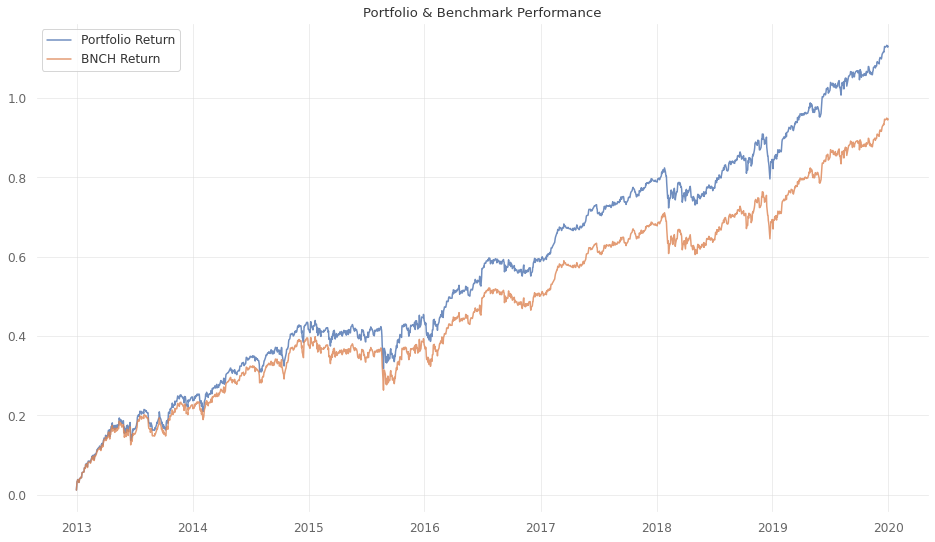

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(ptf_return[cut_date:].cumsum(), alpha=0.8, label='Portfolio Return')
plt.plot(bnch_return[cut_date:].cumsum(), alpha=0.8, label='BNCH Return')
plt.legend()
plt.title('Portfolio & Benchmark Performance')
plt.show()

In [ ]:
print(f"""
Out of sample Sharpe Ratio of Portfolio: 
    {np.sqrt(251)*ptf_return[cut_date:].mean()/ptf_return[cut_date:].std():.2f}
Cumulative Return of Portfolio: 
    {ptf_return[cut_date:].sum()*100:.2f}%

Out of sample Sharpe Ratio of Benchmark: 
    {np.sqrt(251)*bnch_return[cut_date:].mean()/bnch_return[cut_date:].std():.2f}
Cumulative Return of Portfolio: 
    {bnch_return[cut_date:].sum()*100:.2f}%
""")


Out of sample Sharpe Ratio of Portfolio: 
    1.48
Cumulative Return of Portfolio: 
    113.11%

Out of sample Sharpe Ratio of Benchmark: 
    1.24
Cumulative Return of Portfolio: 
    94.78%



[Performance Metrics]

                    Strategy
------------------  ----------
Start Period        2012-12-31
End Period          2019-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   197.26%
CAGR%               16.83%

Sharpe              1.49
Sortino             2.16
Sortino/√2          1.52

Max Drawdown        -11.87%
Longest DD Days     327

Gain/Pain Ratio     0.29
Gain/Pain (1M)      2.5

Payoff Ratio        1.01
Profit Factor       1.29
Common Sense Ratio  1.35
CPC Index           0.73
Tail Ratio          1.04
Outlier Win Ratio   3.37
Outlier Loss Ratio  3.8

MTD                 4.2%
3M                  6.85%
6M                  12.0%
YTD                 32.34%
1Y                  33.37%
3Y (ann.)           19.26%
5Y (ann.)           14.33%
10Y (ann.)          16.83%
All-time (ann.)     16.83%

Avg. Drawdown       -1.24%
Avg. Drawdown Days  15
Recovery Factor     16.61
Ulcer Index         1.01



[Strategy Visualization]
via Matplotlib


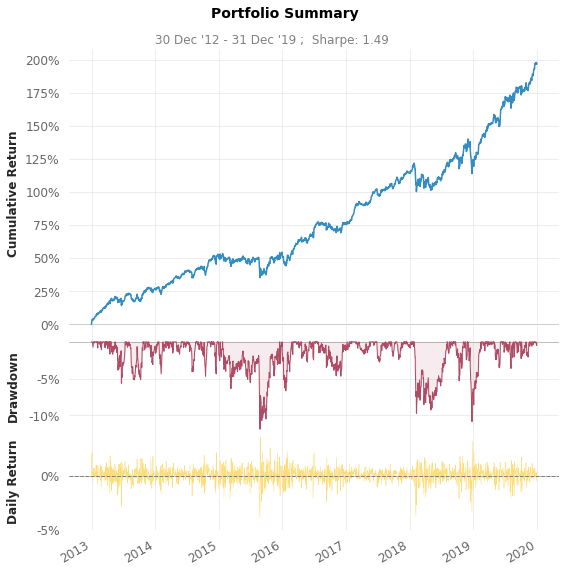

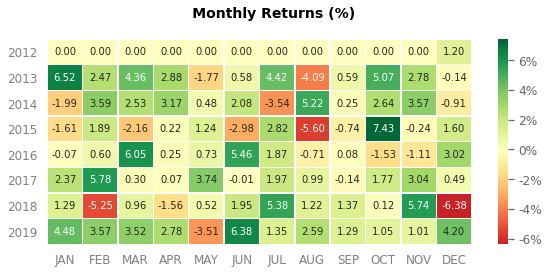

In [ ]:
qs.reports.basic(ptf_return[cut_date:])

[Performance Metrics]

                    Strategy
------------------  ----------
Start Period        2012-12-31
End Period          2019-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   147.49%
CAGR%               13.82%

Sharpe              1.25
Sortino             1.78
Sortino/√2          1.26

Max Drawdown        -13.02%
Longest DD Days     412

Gain/Pain Ratio     0.24
Gain/Pain (1M)      1.87

Payoff Ratio        1.01
Profit Factor       1.24
Common Sense Ratio  1.28
CPC Index           0.69
Tail Ratio          1.03
Outlier Win Ratio   3.35
Outlier Loss Ratio  3.81

MTD                 4.13%
3M                  6.22%
6M                  10.42%
YTD                 28.23%
1Y                  29.2%
3Y (ann.)           15.49%
5Y (ann.)           11.08%
10Y (ann.)          13.82%
All-time (ann.)     13.82%

Avg. Drawdown       -1.31%
Avg. Drawdown Days  17
Recovery Factor     11.33
Ulcer Index         1.01



[Strategy Visualization]
via Matplotlib


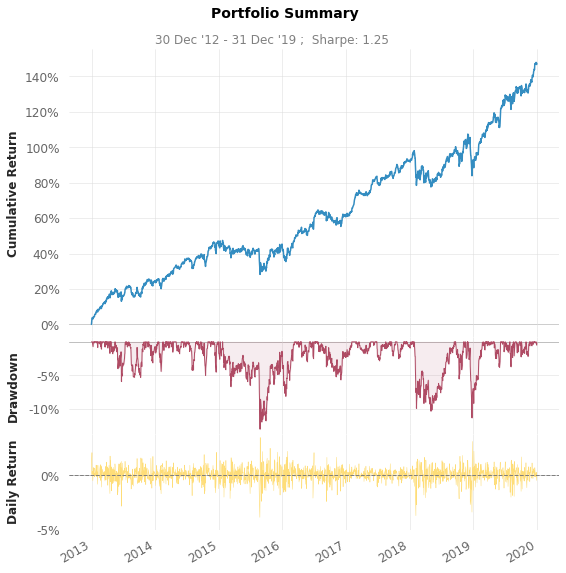

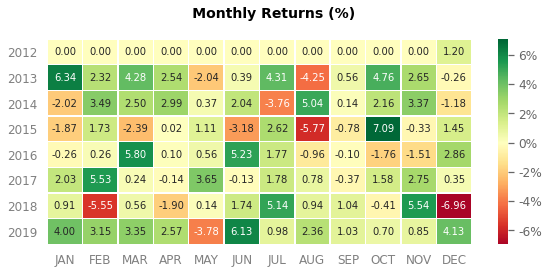

In [ ]:
qs.reports.basic(bnch_return[cut_date:])

We can see that our portfolio consistently outperform the benchmark. Given the strictive constraints about the divergence, we can say that our agent is quite successful!

* The cumulative return of our portfolio (197.24%) is 50% higher than that of benchmark (147.49%).
* The Sharpe ratio is also much higher: 1.49 vs 1.25. 
* The maximum drawdown and average drawdown of our portfolio is also lower.

If we look at the monthly return matrix, we can see that our professional robot kid almost always outperform the monthly benchmark return in the same period.

# Sharpe Ratio Development

Now we have a look of the Sharpe Ratio: How the agent performs during training.

We read the text file recording the Sharpe Ratio and plot it. We select only the first 320 records because after that we have records of later fine-tune or experiments. Unfortunately, this was my mistake that we didn't differentiate the results from different training. This is a potential improvement of the codes.

In [ ]:
with open('/content/drive/My Drive/Quant/20210327/sharpe_train.txt', 'r') as f:
    sp_hist = f.read()
sp_hist = sp_hist.split('\n')

In [ ]:
sp_history = {'Portfolio_SP':[],
              'BNCH_SP':[]}
for s in sp_hist[:320]:
    sp_history['Portfolio_SP'].append(float(s.split(',')[0].strip()))
    sp_history['BNCH_SP'].append(     float(s.split(',')[1].strip()))

sp_history = pd.DataFrame(sp_history)
print(sp_history.shape)
sp_history.head()

(320, 2)


,Portfolio_SP,BNCH_SP
0,0.294203,0.297691
1,0.297283,0.297691
2,0.295854,0.297691
3,0.300395,0.297691
4,0.300899,0.297691


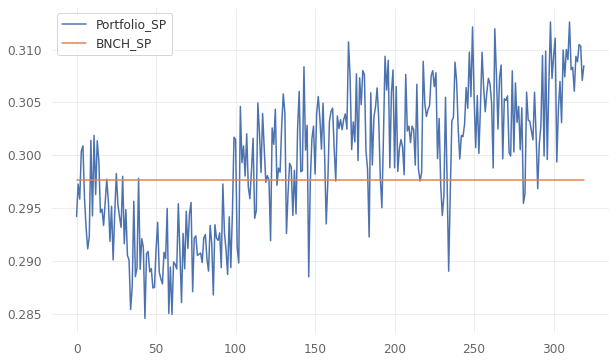

In [ ]:
sp_history.plot()
plt.show()

**From the chart, we can see that after many episodes of training, the agent starts performing better than the benchmark on the perspective of Sharpe Ratio.** There is still an upward trend of the portfolio Sharpe ratio, but as we mentioned, the improvement is marginal.

# Summary

We hope this project shows how RL agent can trade stocks with consideration of constraints. This work was inspired by the paper [Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3690996) presented on ICAIF 2020. However, we have simplified their approach and made it suitable for our task.

Compared to their paper, we assumes:

1. the stocks can be split infintely as long as the weights sum up to one, i.e. the number of stocks can be fractional.
2. there is no transaction fee.
3. we can always trade the amount we need at the close price.
4. we do not care the absolute amount of money, it can be arbitrarily large or small. However, that's not the case in real market.

Besides, we do not use technical indicators, but rather fama french factors and option metrics. We also did not consider other models given the time limit, however, the DDPG algorithm should fit this task quite well because the action space will not be trimed to the upper and lower boundary as we had in our PPO model.

The DDPG algorithm can be called using:

~~~python
from stable_baselines import DDPG
from stable_baselines.ddpg.policies import DDPGPolicy
~~~

We hope we can try this model later in private time and introduce more realistic environment. We believe that introducing the transaction fee can significantly change the results.

In conclusion:

* Our RL agent can outperform the benchmark given constraints and will prevent from overfitting, which is a normal problem of machine learning algorithms.
* Our RL agent can adapt to new environment given proper updated training.
* It can serve for other experimental purpose because it is human-like but extremly rational.
* Except for the unrealistic assumption we made, **the frequency of our data does not match with each other**. For example, the fama french betas and returns are at daily basis, but the rest are calculated on monthly basis. We have tried align the frequency, but the performance is worse. This could be the reason that the amount of data is not enough. Since the policy neural network is a "blackbox" and is hard to trace, it is not easy to explain the good or bad performance.
* We expect a much better performance (and actually we had it) if the constraints can be looser and the agent can choose the weights more freely or independently.

Nevertheless, we hope this work using new technology can be inspirational!


In [ ]:
# total_return = ptf_return[cut_date:].sum()
ptf_total_return = (1 + ptf_return[cut_date:]).prod() - 1
total_years = ptf_return[cut_date:].index.max().year - ptf_return[cut_date:].index.min().year
ptf_ann_return = (ptf_total_return + 1) ** (1 / total_years) - 1
print(f"""
Annualized return - Portfolio: {ptf_ann_return * 100:.2f}%
Annualized std - Portfolio:    {ptf_return[cut_date:].std() * np.sqrt(251) * 100:.2f}%
Sharpe Ratio - Portfolio:      {np.sqrt(251) * ptf_return[cut_date:].mean()/ptf_return[cut_date:].std():.2f}
""")


Annualized return - Portfolio: 16.84%
Annualized std - Portfolio:    10.84%
Sharpe Ratio - Portfolio:      1.48



In [ ]:
bnch_total_return = (1 + bnch_return[cut_date:]).prod() - 1
bnch_ann_return = (bnch_total_return + 1) ** (1 / total_years) - 1
print(f"""
Annualized return - Bench:     {bnch_ann_return * 100:.2f}%
Annualized std - Portfolio:    {bnch_return[cut_date:].std() * np.sqrt(251) * 100:.2f}%
Sharpe Ratio - Portfolio:      {np.sqrt(251) * bnch_return[cut_date:].mean()/bnch_return[cut_date:].std():.2f}
""")


Annualized return - Bench:     13.82%
Annualized std - Portfolio:    10.85%
Sharpe Ratio - Portfolio:      1.24

